In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import kliep

## Multivariate Gaussian 1

In [ ]:
tmis = [-0.5 * np.log(1 - c**2) for c in np.arange(0, 1, 0.1)]

In [ ]:
mis = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    cov = np.array([[1, c], [c, 1]])
    XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(1000)
    X, Y = np.split(XY, [1], axis=1)
    mis += [kliep.mutual_information(X, Y, sigma=0.5)]

In [ ]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), mis, label='approx.')
plt.legend()

## Multivariate Gaussian 2

In [ ]:
pre = [[1,   0.8,    0],
       [0.8,   1, -0.4],
       [0,  -0.4,    1]]
cov = np.linalg.inv(pre)
diag = np.sqrt(np.diag(cov))
cov = cov / diag.reshape(-1, 1) / diag.reshape(1, -1)
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

In [ ]:
sns.pairplot(pd.DataFrame(X).sample(300))
plt.tight_layout()
plt.savefig('output/pair-gaussian.pdf', format='pdf')

In [ ]:
H = np.linalg.slogdet(cov)[1] / 2
H1 = [np.linalg.slogdet(np.delete(np.delete(cov, [i], axis=0), [i], axis=1))[1] / 2 for i in range(3)]
H2 = [[np.linalg.slogdet(np.delete(np.delete(cov, [i, j], axis=0), [i, j], axis=1))[1] / 2 for i in range(3)] for j in range(3)]
tmi = np.array([[H1[i] + H1[j] - (H + H2[i][j]) for i in range(3)] for j in range(3)])
tmi[np.eye(3, dtype=bool)] = None
plt.figure(figsize=[5, 5])
sns.heatmap(tmi, annot=True, center=0, cmap=palette, cbar=False)

In [ ]:
# pre = sklearn.covariance.GraphLasso(alpha=0.02).fit(X).precision_
mi = kliep.calc_mi_matrix(X)
cmi = kliep.calc_cmi_matrix(X)
cmi2 = kliep.calc_cmi_matrix2(X)

In [ ]:
f, axes = plt.subplots(1, 3, figsize=[11.5, 4])
axes[0].set_title('Graphical Lasso', fontsize=15)
axes[1].set_title('Mutual Information', fontsize=15)
axes[2].set_title('Conditional Mutual Information', fontsize=15)
# sns.heatmap(pre, annot=True, ax=axes[0], center=0, cmap=palette, cbar=False)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette, cbar=False)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette, cbar=False)
sns.heatmap(cmi2, annot=True, ax=axes[0], center=0, cmap=palette, cbar=False)
plt.tight_layout()
plt.savefig('output/heat-gaussian.pdf', format='pdf')

## Multivariate Gaussian Mixuture

In [ ]:
X1 = scipy.stats.multivariate_normal(mean=[-4,  0,  0], cov=np.eye(3)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+4,  0,  0], cov=[[1, 0, 0], [0, 6, 0], [0, 0, 1]]).rvs(500)
X = np.vstack([X1, X2])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X.shape

In [ ]:
sns.pairplot(pd.DataFrame(X).sample(300))
plt.tight_layout()
plt.savefig('output/pair-gaussian-mixture.pdf', format='pdf')

In [ ]:
pre = sklearn.covariance.GraphLasso(alpha=0.02).fit(X).precision_
mi = kliep.calc_mi_matrix(X)
cmi = kliep.calc_cmi_matrix(X)
cmi2 = kliep.calc_cmi_matrix2(X)

In [ ]:
f, axes = plt.subplots(1, 3, figsize=[11.5, 4])
axes[0].set_title('Graphical Lasso', fontsize=15)
axes[1].set_title('Mutual Information', fontsize=15)
axes[2].set_title('Conditional Mutual Information', fontsize=15)
sns.heatmap(pre, annot=True, ax=axes[0], center=0, cmap=palette, cbar=False)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette, cbar=False)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette, cbar=False)
# sns.heatmap(cmi2, annot=True, ax=axes[0], center=0, cmap=palette, cbar=False)
plt.tight_layout()
plt.savefig('output/heat-gaussian-mixture.pdf', format='pdf')

## Stochastic volatility model

$$
Z_{t+1} = \mu + \phi(Z_t - \mu) + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, 1)
$$
$$
Z_0\mid \mu,\phi \sim \mathcal{N}\left(\mu, \frac{1}{1-\phi^2}\right),\quad \mu\sim \mathcal{N}(0, 1)
$$
$$
\phi = \frac{2e^{\phi^*}}{1 + e^{\phi^*}} - 1, \quad \phi^* \sim \mathcal{N}(3, 1).
$$

In [2]:
X = []
for n in tqdm.tqdm(range(15000)):
    phi_star = scipy.stats.norm(3, 1).rvs()
    phi = 2 * np.exp(phi_star) / (1 + np.exp(phi_star)) - 1
    mu = scipy.stats.norm(0, 1).rvs()
    z = [scipy.stats.norm(mu, 1 / (1 - phi**2)).rvs()]
    for i in range(6):
        z += [mu + phi * (z[i] - mu) + scipy.stats.norm(0, 1).rvs()]
    X += [[mu, phi] + z[1:]]
    
X = np.array(X)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

100%|██████████| 15000/15000 [01:17<00:00, 194.57it/s]


In [ ]:
pre = sklearn.covariance.GraphLasso(alpha=0.15, assume_centered=True).fit(X).precision_

In [7]:
mi = kliep.calc_mi_matrix(X)

100%|██████████| 28/28 [03:19<00:00,  7.33s/it]


In [10]:
cmi2 = kliep.calc_cmi_matrix2(X, sigma=0.7, maxiter=5000)

 39%|███▉      | 11/28 [05:20<08:45, 30.94s/it]/home/ytakashina/workspace/density_ratio/kliep.py:46: RuntimeWarning:

divide by zero encountered in log

Optimization failed: Iteration limit exceeded
100%|██████████| 28/28 [14:16<00:00, 28.86s/it]
/home/ytakashina/workspace/density_ratio/kliep.py:100: RuntimeWarning:

invalid value encountered in less



In [12]:
cmi = kliep.calc_cmi_matrix(X, maxiter=5000)

100%|██████████| 28/28 [24:53<00:00, 70.23s/it]


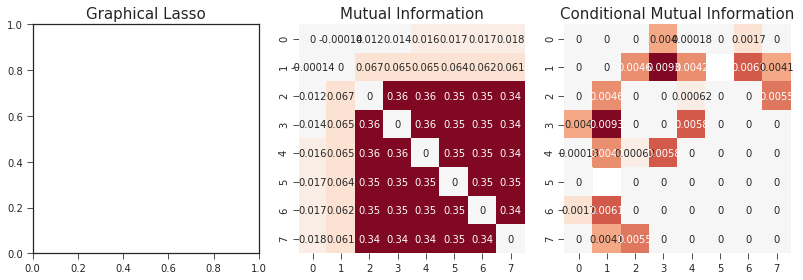

In [13]:
f, axes = plt.subplots(1, 3, figsize=[11.5, 4])
axes[0].set_title('Graphical Lasso', fontsize=15)
axes[1].set_title('Mutual Information', fontsize=15)
axes[2].set_title('Conditional Mutual Information', fontsize=15)
# sns.heatmap(pre, annot=True, ax=axes[0], center=0, cmap=palette, cbar=False)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette, cbar=False)
sns.heatmap(cmi2, annot=True, ax=axes[2], center=0, cmap=palette, cbar=False)
plt.tight_layout()